# Configurando e automatizando a interação com um gráfico web usando Selenium

Este é um exemplo de como configurar e automatizar a interação com um gráfico em uma página da web usando o Selenium WebDriver em Python.

## Motivação

Às vezes, precisamos automatizar tarefas de interação com páginas da web, como fazer capturas de tela de gráficos ou extrair dados deles. O Selenium é uma ferramenta poderosa para automatizar essas interações.

## Passos

### 1. Configurando o Driver

- Importamos as bibliotecas necessárias do Selenium e configuramos o driver do Chrome.
- Escolhemos opções para o navegador, como tamanho da janela e maximização da mesma.
- Configuramos a estratégia de carregamento da página para garantir que a página seja carregada completamente antes de prosseguir.

### 2. Abrindo o Site e Preparando o Gráfico

- Definimos uma função para abrir um site específico e garantir que um elemento específico (o gráfico) esteja visível.
- Utilizamos o XPath para localizar o elemento do gráfico na página.
- Esperamos até que o elemento esteja presente no DOM e visível na página.
- Se bem-sucedido, a função retorna o elemento do gráfico para interações futuras.
- Caso contrário, tratamos exceções e informamos sobre falhas.

### 3. Exemplo de Uso

- Configuramos o driver e abrimos o site de exemplo.
- Verificamos se o elemento do gráfico foi carregado com sucesso.
- Se o elemento do gráfico estiver disponível, confirmamos que está pronto para interação.

Com o Selenium, podemos automatizar a interação com elementos da web, como gráficos, facilitando a captura de dados ou a execução de tarefas repetitivas em páginas da web.



In [12]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options

# Variável global para o driver
global driver

def setup_driver():
    """Configura o Selenium WebDriver globalmente."""
    global driver
    options = Options()
    options.add_argument("--window-size=1920,1080")  # Garante que a janela seja grande o suficiente para exibir todos os elementos.
    options.add_argument("--start-maximized")  # Inicia o navegador maximizado para garantir que todos os elementos sejam visíveis.
    options.page_load_strategy = 'normal'  # Garante que o driver espere as páginas carregarem completamente.
    service = ChromeService(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

def open_website_and_prepare_graph(url, graph_xpath):
    """Abre um site e garante que um elemento específico (gráfico) seja visível."""
    global driver
    try:
        driver.get(url)
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, graph_xpath)))  # Verifica se o elemento está no DOM.
        graph = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.XPATH, graph_xpath)))  # Aguarda até que o elemento seja visível.
        driver.execute_script("arguments[0].scrollIntoView(true);", graph)  # Faz a página rolar para tornar o elemento visível.
        print("O gráfico está preparado e visível.")
        return graph  # Retorna o elemento do gráfico para ações posteriores, se necessário.
    except Exception as e:
        print(f"Falha ao abrir o site e preparar o gráfico: {e}")
        return None

# Exemplo de configuração do driver e abertura do site
setup_driver()
graph_element = open_website_and_prepare_graph("https://pricehistoryapp.com/product/apple-iphone-x-64gb-space-grey", "//div[contains(@class, 'apexcharts-canvas')]")

if graph_element:
    print("O elemento do gráfico foi carregado com sucesso e está pronto para interação.")
else:
    print("Houve um problema ao carregar o elemento do gráfico.")


O gráfico está preparado e visível.
O elemento do gráfico foi carregado com sucesso e está pronto para interação.


A função a seguir tem como objetivo extrair os dados utilizando a instância ActionChains para simular ações de mouse.


### Estimativa do Tamanho do Passo:
- Obtém a largura do gráfico para estimar o tamanho do passo para cada ponto de dados.

- Define um passo de 1 pixel para cada ponto de dados, assumindo uma largura padrão.
### Captura de Dados do Tooltip:
- Inicia um loop para percorrer os pontos de dados ao longo do eixo x do gráfico.


- Move o cursor do mouse em pequenos incrementos ao longo do eixo x usando move_to_element_with_offset().


- Aguarda a visibilidade do tooltip após o movimento do mouse.

- Extrai a data e o preço do tooltip e os armazena em um dicionário.

- Adiciona o dicionário contendo os dados capturados à lista all_data.

### Tratamento de Exceções:
- Captura a exceção MoveTargetOutOfBoundsException se o mouse tentar se mover para fora da tela.

- Imprime uma mensagem indicando que o mouse tentou se mover para fora dos limites da tela e interrompe a captura de dados.

In [ ]:
from selenium.common.exceptions import NoSuchElementException, TimeoutException, MoveTargetOutOfBoundsException
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def capturar_dados_tooltip():
    global driver

    # Encontra o elemento do gráfico na página
    graph = driver.find_element(By.CLASS_NAME, 'apexcharts-canvas')
    action = ActionChains(driver)
    
    # Obtém as dimensões do gráfico para estimar os pontos de dados
    largura = graph.size['width']
    passo = 1  # Estima o tamanho do passo para cada ponto de dados com base na largura do gráfico
    
    # Esta lista conterá todos os dados capturados como dicionários
    todos_os_dados = []
    try:
        # Passa o mouse sobre o gráfico e captura os dados
        for x_offset in range(-600, largura, passo):
            action.move_to_element_with_offset(graph, x_offset, 10).perform()  # Move-se em pequenos incrementos ao longo do eixo x.
            try:
                WebDriverWait(driver, 1).until(
                    EC.visibility_of_element_located((By.CLASS_NAME, "apexcharts-tooltip-text"))
                )
                data_texto = driver.find_element(By.CLASS_NAME, "apexcharts-tooltip-title").text
                preco_texto = driver.find_elements(By.CLASS_NAME, "apexcharts-tooltip-text-y-value")[0].text.replace('₹', '').replace(',', '')
                todos_os_dados.append({'Data': data_texto, 'Preço': preco_texto})
                print(f"Dados capturados em deslocamento X {x_offset}: Data: {data_texto}, Preço: {preco_texto}")
            except TimeoutException:
                print(f"Nenhum tooltip encontrado em deslocamento X {x_offset}.")
    except MoveTargetOutOfBoundsException:
        # Se o mouse tentar se mover para fora da tela, pare a captura de dados
        print("MoveTargetOutOfBoundsException: O mouse tentou sair dos limites da tela. Parando a captura de dados.")
    
    return todos_os_dados


In [ ]:
import pandas as pd

# Capturar todos os dados do tooltip
todos_os_dados_tooltip = capturar_dados_tooltip()

# Converter a lista de dicionários para um DataFrame do pandas
df = pd.DataFrame(todos_os_dados_tooltip)
print(df.head())  # Imprimir as primeiras linhas do DataFrame

# Salvar o DataFrame em um arquivo CSV, se necessário
df.to_csv('dados_do_historico_de_preco.csv', index=False)


Data captured at X-offset -600: Date: 07 Jan 2021, Price: 69.999
Data captured at X-offset -590: Date: 07 Jan 2021, Price: 69.999
Data captured at X-offset -580: Date: 07 Jan 2021, Price: 69.999
Data captured at X-offset -570: Date: 07 Jan 2021, Price: 69.999
Data captured at X-offset -560: Date: 07 Jan 2021, Price: 69.999
Data captured at X-offset -550: Date: 07 Jan 2021, Price: 69.999
Data captured at X-offset -540: Date: 26 Sep 2019, Price: 72.500
Data captured at X-offset -530: Date: 04 Oct 2019, Price: 59.999
Data captured at X-offset -520: Date: 14 Oct 2019, Price: 59.999
Data captured at X-offset -510: Date: 23 Oct 2019, Price: 59.999
Data captured at X-offset -500: Date: 02 Nov 2019, Price: 84.099
Data captured at X-offset -490: Date: 06 Nov 2019, Price: 84.099
Data captured at X-offset -480: Date: 17 Nov 2019, Price: 83.499
Data captured at X-offset -470: Date: 19 Nov 2019, Price: 79.990
Data captured at X-offset -460: Date: 16 Dec 2019, Price: 84.999
Data captured at X-offset

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.read_csv('dados_do_historico_de_preco.csv')
# Remover duplicatas
df.drop_duplicates(inplace=True)



In [18]:
# Ordenar os valores pela data
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)


In [20]:
df

,Date,Price
6,2019-09-26,72.500
7,2019-10-04,59.999
8,2019-10-14,59.999
9,2019-10-23,59.999
10,2019-11-02,84.099
...,...,...
117,2022-04-25,64.876
118,2022-05-04,64.876
119,2022-05-11,64.876
120,2022-05-20,64.876


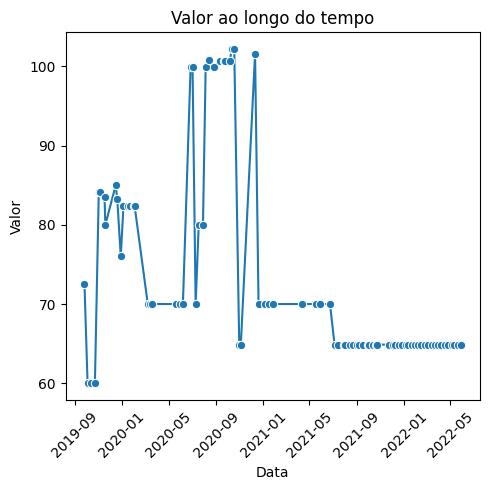

In [23]:
# Plotar o gráfico de linha
plt.figure(figsize=(5, 5))
sns.lineplot(x='Date', y='Price', data=df, marker='o')  # Substituir 'Value' por 'Price'
plt.title('Valor ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [25]:
# Calcular estatísticas descritivas
stats = df.describe()
print("Estatísticas Descritivas:\n", stats)

# Calcular a média móvel
rolling_mean = df['Price'].rolling(window=3).mean()
print("\nMédia Móvel (window=3):\n", rolling_mean)

Estatísticas Descritivas:
                                 Date       Price
count                             84   84.000000
mean   2021-02-15 12:51:25.714285824   73.677298
min              2019-09-26 00:00:00   59.999000
25%              2020-06-05 00:00:00   64.876000
50%              2021-01-21 00:00:00   67.437500
75%              2021-12-04 12:00:00   82.343000
max              2022-05-29 00:00:00  102.180000
std                              NaN   12.808656

Média Móvel (window=3):
 6            NaN
7            NaN
8      64.166000
9      59.999000
10     68.032333
         ...    
117    64.876000
118    64.876000
119    64.876000
120    64.876000
121    64.876000
Name: Price, Length: 84, dtype: float64


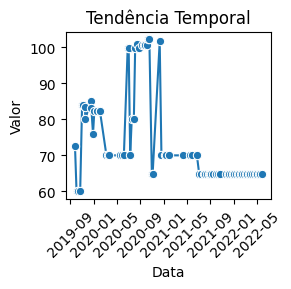

In [29]:
# Identificar tendências temporais
plt.figure(figsize=(3, 3))
sns.lineplot(x='Date', y='Price', data=df, marker='o')
plt.title('Tendência Temporal')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



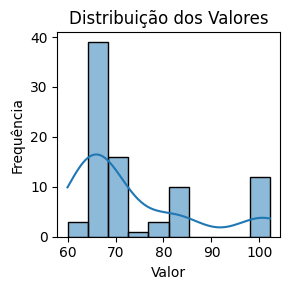

In [31]:
# Verificar a distribuição dos valores
plt.figure(figsize=(3, 3))
sns.histplot(df['Price'], bins=10, kde=True)
plt.title('Distribuição dos Valores')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()



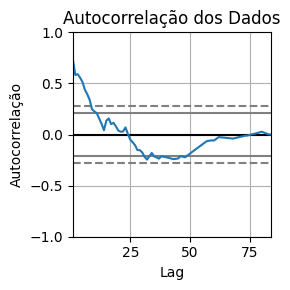

In [32]:
# Analisar a autocorrelação dos dados
plt.figure(figsize=(3, 3))
pd.plotting.autocorrelation_plot(df['Price'])
plt.title('Autocorrelação dos Dados')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.tight_layout()
plt.show()

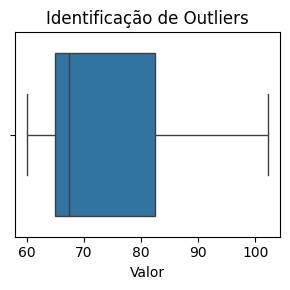

In [35]:
# Identificar outliers
plt.figure(figsize=(3, 3))
sns.boxplot(data=df, x='Price')
plt.title('Identificação de Outliers')
plt.xlabel('Valor')
plt.tight_layout()
plt.show()



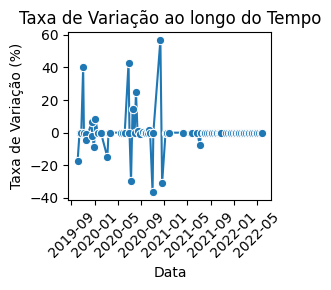

In [36]:
# Calcular a taxa de variação
df['Variation'] = df['Price'].pct_change() * 100
plt.figure(figsize=(3, 3))
sns.lineplot(x='Date', y='Variation', data=df, marker='o')
plt.title('Taxa de Variação ao longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Taxa de Variação (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()